In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
import math
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datetime
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import sparse
import pickle
import joblib

[nltk_data] Downloading package punkt to C:\Users\Tejas
[nltk_data]     Chavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tejas
[nltk_data]     Chavan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<p style='font-size:20px'><b> Modelling </b></p>
<p>

- Now that we have the trainable data with numerical features, we can build models for Tag prediction.
- For all the models, we will implement a OnevsRest strategy to predict 0/1 values individually for each of the 500 Tags accross all datapoints.
- We will begin by testing logreg since it is the most basic model for classification.

</p>

In [2]:
# Load the processed, featurized train & test data 
train_x = sparse.load_npz("E:/ai_projects/data_storage/Stack over flow tagging 5/dataset/train_x.npz")
train_y = sparse.load_npz("E:/ai_projects/data_storage/Stack over flow tagging 5/dataset/train_y.npz")
cv_x = sparse.load_npz("E:/ai_projects/data_storage/Stack over flow tagging 5/dataset/cv_x.npz")
cv_y = sparse.load_npz("E:/ai_projects/data_storage/Stack over flow tagging 5/dataset/cv_y.npz")
test_x = sparse.load_npz("E:/ai_projects/data_storage/Stack over flow tagging 5/dataset/test_x.npz")
test_y = sparse.load_npz("E:/ai_projects/data_storage/Stack over flow tagging 5/dataset/test_y.npz")
vocab = pickle.load(open("E:/ai_projects/data_storage/Stack over flow tagging 5/models/vocab.pickle", "rb"))

In [3]:
print(train_x.shape)
print(train_y.shape)
print(cv_x.shape)
print(cv_y.shape)
print(test_x.shape)
print(test_y.shape)

(100000, 200000)
(100000, 500)
(25000, 200000)
(25000, 500)
(25000, 200000)
(25000, 500)


<p style='font-size:18px'><b> Custom function </b></p>
<p style='font-size:16px'><b> 1) Analyse_prediction </b></p>

<p>

This function has been defined to analyse the model performance & operates as following:
    
A) Inputs:
    1. y_actual: Sparse representation of the actual tags to be predicted (Target)
    2. y_pred: Sparse representation of the tags predicted by the model (Prediction)        
    3. num_top_tags: Number of top tags by frequency for which tag-wise metrics will be calculated & displayed
    4. vocab: Dictionary providing the mapping of Tag:Index pairs for the sparse matrices y_actual, y_pred 
    5. header: Heading/title to printed at the top of performance report

B) Outputs:
    1. #tags predicted for each datapoint: In the train data, each datapoint has a maximum of 5 Tags. We will analyse if similar distribution holds for the predictions.
    2. Following metrics will be displayed label-wise for num_top_tags, Micro-avg & Macro-avg over all tags:
        - Accuracy
        - Precision
        - Recall
        - F1 score

</p>

In [4]:
def analyse_prediction(y_actual, y_pred, num_top_tags, vocab, header):
    
    # Metrics part 1:
    # Number of tags predicted to a question, viewing the following few metrics:
    # 1. Plot: Distribution of # of tags predicted vs questions
    # 2. Plot: Distribution of difference (# of tags predicted - # of actual tags) vs questions
    # 3. Metric: Number and % of question with more than 5 predicted tags

    print('\033[1m' + "\n--------- " + header + " ---------\n" + '\033[0m')
    
    fig = plt.figure(figsize = (8,3))
    fig.subplots_adjust(wspace = 0.3)
    axs = fig.subplots(1,2)
    
    # Calculating the number of tags predicted vs number of actual tags for each question
    num_actual = np.zeros(y_actual.shape[0], dtype = 'int')
    num_pred = np.zeros(y_actual.shape[0], dtype = 'int')    
    
    non_zero_vals = y_actual.nonzero()[0]
    datapt_no, num_tags = np.unique(non_zero_vals, return_counts=True)
    num_actual[datapt_no] = num_tags
    
    non_zero_vals = y_pred.nonzero()[0]
    datapt_no, num_tags = np.unique(non_zero_vals, return_counts=True)
    num_pred[datapt_no] = num_tags
    
    
    # 1. Plot
    num_tags, num_datapts = np.unique(num_pred, return_counts=True)
    axs[0].bar(num_tags, num_datapts/1000)
    axs[0].set(xlabel = '# of tags', ylabel = '# of datapts (in thousands)', title = 'Distribution of # tags_pred vs # questions')

    # 2. Plot
    num_vals, num_datapts = np.unique(num_pred - num_actual, return_counts=True)
    axs[1].bar(num_vals, num_datapts/1000)
    axs[1].set(xlabel = 'Diff in # of tags (pred - actual)', ylabel = '# of datapts (in thousands)', title = 'Distribution of diff & # questions')
    
    # 3. Metric
    print("1a. Number & percent of datapoints having more than 5 predicted tags: {}, {}%".format(np.sum(num_pred > 5), round(100*np.sum(num_pred > 5)/y_actual.shape[0],2)))
    print("1b. Number & percent of datapoints having 0 predicted tags: {}, {}%".format(np.sum(num_pred == 0), round(100*np.sum(num_pred == 0)/y_actual.shape[0],2)))
#     print("\n2a. Number & percent of datapoints having more than 5 actual tags: {}, {}%".format(np.sum(num_actual > 5), round(100*np.sum(num_actual > 5)/y_actual.shape[0],2)))
#     print("2b. Number & percent of datapoints having 0 actual tags: {}, {}%".format(np.sum(num_actual == 0), round(100*np.sum(num_actual == 0)/y_actual.shape[0],2)))
    
    
    # Metrics part 2:
    # Label wise & Micro/Macro averaged:
    # 1. Accuracy
    # 2. Precision
    # 3. Recall
    # 4. F1 score
    
    perf_report = []
    perf_report.append(['Tag', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    
    # Getting the top number of tags
    tag_inds = np.arange(0, y_actual.shape[1], 1)
    non_zero_vals = y_actual.nonzero()[1]
    inds, count = np.unique(non_zero_vals, return_counts=True)
    sort_indices = np.argsort(count)[::-1]
    inds = inds[sort_indices]
    top_tag_inds = inds[:num_top_tags]

    for tag_ind in top_tag_inds:
        
        temp_report = []
        
        # Adding the label name in the report 
        temp_report.append(list(vocab.keys())[list(vocab.values()).index(tag_ind)])
        
        tag_actual = y_actual[:, tag_ind].toarray()
        tag_pred = y_pred[:, tag_ind].toarray()
        
        # Calculating the specified metrics
        acc = accuracy_score(tag_actual, tag_pred)
        prec = precision_score(tag_actual, tag_pred)
        rec = recall_score(tag_actual, tag_pred)
        f1_scr = f1_score(tag_actual, tag_pred)
        
        # Adding the specified metrics to the report
        temp_report = temp_report + [acc, prec, rec, f1_scr]
        
        # Adding tag metrics to the final report
        perf_report.append(temp_report)
        
        
    # Calculating the metrics at a micro-averaged level
    temp_report = []
    temp_report.append('Micro-avg')
    acc = accuracy_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred, average = 'micro')
    rec = recall_score(y_actual, y_pred, average = 'micro')
    f1_scr = f1_score(y_actual, y_pred, average = 'micro')
    temp_report = temp_report + [acc, prec, rec, f1_scr]
    perf_report.append(temp_report)
    
    # Calculating the metrics at a macro-averaged level
    temp_report = []
    temp_report.append('Macro-avg')
    acc = accuracy_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred, average = 'macro')
    rec = recall_score(y_actual, y_pred, average = 'macro')
    f1_scr = f1_score(y_actual, y_pred, average = 'macro')
    temp_report = temp_report + [acc, prec, rec, f1_scr]
    perf_report.append(temp_report)
    
    
    # Printing the final report
    print("\n\n2. Tag wise metrics: \n")
    col_width = 10
    print(perf_report[0][0].ljust(col_width), end = "")
    print("".join(word.center(col_width) for word in perf_report[0][1:]))
    print("------------------------------------------------")
    
    for row in perf_report[1:-2]:
        temp_tag = str(row[0])
        temp_acc = str(round(100*row[1],1)) + '%'
        temp_prec = str(round(100*row[2],1)) + '%'
        temp_rec = str(round(100*row[3],1)) + '%'
        temp_f1 = str(round(100*row[4],1)) + '%'
        
        print(temp_tag.ljust(col_width), end = "")
        print(temp_acc.center(col_width), end = "")
        print(temp_prec.center(col_width), end = "")
        print(temp_rec.center(col_width), end = "")
        print(temp_f1.center(col_width))
    
    print('\033[1m')
    for row in perf_report[-2:]:
        temp_tag = str(row[0])
        temp_acc = str(round(100*row[1],1)) + '%'
        temp_prec = str(round(100*row[2],1)) + '%'
        temp_rec = str(round(100*row[3],1)) + '%'
        temp_f1 = str(round(100*row[4],1)) + '%'
        
        print(temp_tag.ljust(col_width), end = "")
        print(temp_acc.center(col_width), end = "")
        print(temp_prec.center(col_width), end = "")
        print(temp_rec.center(col_width), end = "")
        print(temp_f1.center(col_width))
    print('\033[0m')        

<p style='font-size:18px'><b> Basic Logistic regression </b></p>

In [5]:
start_time = datetime.datetime.now()

# Using penalty = 'l2' yielded worse results
log_reg_clf1 = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1', max_iter = 5000))
log_reg_clf1.fit(train_x, train_y)

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:34:01.442528


In [6]:
print([estimator.n_iter_ for estimator in log_reg_clf1.estimators_])

[7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 6, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 6, 7, 8, 7, 6, 8, 7, 7, 8, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 


--------- Log-reg (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 18, 0.02%
1b. Number & percent of datapoints having 0 predicted tags: 26283, 26.28%


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.8%     74.9%     44.3%     55.7%   
java        95.8%     84.1%     57.1%     68.0%   
php         96.7%     87.5%     65.2%     74.7%   
javascript  95.7%     80.9%     50.4%     62.1%   
android     98.7%     96.4%     82.2%     88.7%   
jquery      97.8%     88.7%     71.4%     79.1%   
c++         97.7%     83.5%     48.1%     61.0%   
python      98.7%     91.4%     70.5%     79.6%   
mysql       98.6%     89.0%     65.0%     75.2%   
iphone      97.7%     74.7%     47.4%     58.0%   

Micro-avg   22.0%     77.5%     42.6%     55.0%   
Macro-avg   22.0%     62.6%     32.3%     40.9%   


Block execution time:  0:16:38.233265


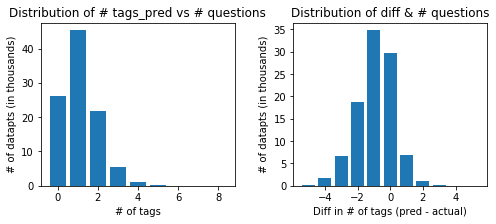

In [7]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = log_reg_clf1.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Log-reg (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Log-reg (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 7, 0.03%
1b. Number & percent of datapoints having 0 predicted tags: 6288, 25.15%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.4%     69.6%     42.6%     52.9%   
java        95.7%     82.1%     58.2%     68.1%   
php         96.7%     85.7%     65.3%     74.1%   
javascript  95.5%     79.5%     49.4%     60.9%   
android     98.6%     96.4%     80.8%     87.9%   
jquery      97.6%     89.3%     69.6%     78.2%   
c++         97.4%     76.7%     46.8%     58.1%   
python      98.5%     90.3%     65.6%     76.0%   
iphone      97.3%     63.9%     42.3%     50.9%   
html        97.0%     57.7%     30.5%     39.9%   

Micro-avg   20.2%     73.5%     42.2%     53.6%   
Macro-avg   20.2%     58.0%     32.0%     39.8%   


Block execution time:  0:03:09.201848


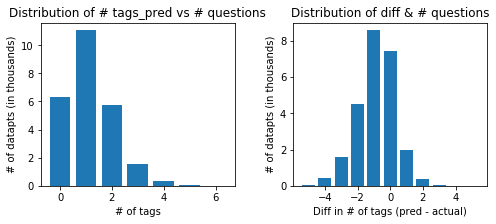

In [8]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = log_reg_clf1.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Log-reg (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

In [12]:
def grid_search_cv(hyper_params, train_x, train_y, cv_x, cv_y):
    
    # Creating the mesh grid of hyperparameters as a pandas dataframe
    hyper_param_grid = pd.DataFrame()
    alpha_vals = hyper_params['alpha']
    penalty_vals = hyper_params['penalty']
    temp = []
    
    for alpha_val in alpha_vals:
        for penalty_val in penalty_vals:
            temp.append((alpha_val, penalty_val))
            
    hyper_param_grid['alpha'] = [x for (x, y) in temp]
    hyper_param_grid['penalty'] = [y for (x, y) in temp]
    hyper_param_grid['train_score'] = np.zeros(len(temp))
    hyper_param_grid['cv_score'] = np.zeros(len(temp))
    
    
    # Iterating over the mesh grid and training models for each hyper parameter combination
    best_cv_score = 0
    best_estimator = 0
    best_params = {'alpha': 0, 'penalty': 0}
    
    start_ = datetime.datetime.now()
    for i in range(hyper_param_grid.shape[0]):
        
        alpha_val = hyper_param_grid.alpha.iloc[i]
        penalty_val = hyper_param_grid.penalty.iloc[i]
        
        # Model training
        logreg = OneVsRestClassifier(SGDClassifier(alpha = alpha_val, penalty = penalty_val, loss='log', max_iter=2000))
        logreg.fit(train_x, train_y)
        
        # Model prediction on train data
        y_pred_train = logreg.predict(train_x)
        train_scr = f1_score(train_y, y_pred_train, average = 'micro')
        hyper_param_grid.train_score.iloc[i] = train_scr
        
        # Model prediction on CV data
        y_pred_cv = logreg.predict(cv_x)
        cv_scr = f1_score(cv_y, y_pred_cv, average = 'micro')
        hyper_param_grid.cv_score.iloc[i] = cv_scr
        
        # Save this model if it is the best estimator so far
        if cv_scr > best_cv_score:
            best_cv_score = cv_scr
            best_estimator = logreg # is .copy necessary here?
            best_params = {'alpha': alpha_val, 'penalty': penalty_val}
        
        # Verbose the progress & time taken for latest iteration
        end_ = datetime.datetime.now() - start_
        print("Completed iteration: {}/{} | Time taken: {}".format(i+1, hyper_param_grid.shape[0]+1, end_))
        start_ = datetime.datetime.now()
            
    return {'hyper_param_scores': hyper_param_grid, 'best_estimator': best_estimator, 'best_params': best_params}    
    

In [13]:
start_time = datetime.datetime.now()

# GridSearchCV for hyperparameter tuning of regularization paramter

# Defining the hyper parameter value to be experimented with
hyper_params2 = {'alpha': [10**-6, 10**-4, 10**-2, 10**0, 10**2], 'penalty': ['l2', 'l1', 'elasticnet']}
logreg_gcv2 = grid_search_cv(hyper_params2, train_x, train_y, cv_x, cv_y)

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Completed iteration: 1/16 | Time taken: 0:43:29.282573
Completed iteration: 2/16 | Time taken: 1:00:18.156185
Completed iteration: 3/16 | Time taken: 1:05:42.019593
Completed iteration: 4/16 | Time taken: 0:42:14.898080
Completed iteration: 5/16 | Time taken: 0:50:58.455394
Completed iteration: 6/16 | Time taken: 0:53:29.813648
Completed iteration: 7/16 | Time taken: 0:43:52.738048
Completed iteration: 8/16 | Time taken: 0:51:24.594229
Completed iteration: 9/16 | Time taken: 0:55:01.908609
Completed iteration: 10/16 | Time taken: 0:43:03.742012
Completed iteration: 11/16 | Time taken: 0:53:16.325980
Completed iteration: 12/16 | Time taken: 0:53:24.060281
Completed iteration: 13/16 | Time taken: 0:41:57.051503
Completed iteration: 14/16 | Time taken: 0:49:04.226503
Completed iteration: 15/16 | Time taken: 0:49:08.072435

Block execution time:  12:36:26.825993


In [14]:
print(logreg_gcv2['best_params'])
logreg_gcv2['hyper_param_scores']

{'alpha': 1e-06, 'penalty': 'l1'}


,alpha,penalty,train_score,cv_score
0,0.000001,l2,0.953417,0.539790
1,0.000001,l1,0.975592,0.557440
2,0.000001,elasticnet,0.951049,0.548765
3,0.000100,l2,0.218242,0.218303
4,0.000100,l1,0.374426,0.386239
5,0.000100,elasticnet,0.207709,0.214937
6,0.010000,l2,0.000000,0.000000
7,0.010000,l1,0.000000,0.000000
8,0.010000,elasticnet,0.000000,0.000000
9,1.000000,l2,0.000000,0.000000


In [84]:
def sci_notation(alpha_vals):
    
    sci_num = []
    
    for num in alpha_vals:
        
        pow_10 = int(math.log(num, 10))
        
        if pow_10 > 1:
            quotient_10 = round(num/(10**pow_10), 2)
            sci_num.append(str(quotient_10) + 'e' + str(pow_10))
        elif pow_10 < 0:
            pow_10 = pow_10 - 1
            quotient_10 = round(num/(10**pow_10), 2)
            sci_num.append(str(quotient_10) + 'e' + str(pow_10))
        else:
            quotient_10 = round(num, 2)
            sci_num.append(str(quotient_10))
    
    return sci_num

            
            
def plot_gcv(alpha_vals, train_scores, cv_scores, axs, plot_labels):
    
    # Plot the graph of hyperparam vs train & CV F1-score
    x = np.arange(len(alpha_vals))
    axs.plot(x, train_scores, color = 'b', label = 'Train score')
    axs.plot(x, cv_scores, color = 'r', label = 'CV score')
    axs.xaxis.set_ticks(x)
    alpha_vals = sci_notation(alpha_vals)
    axs.xaxis.set_ticklabels(alpha_vals)
    axs.legend()
    axs.set_ylim([0, 1.5])
    
    # Name the x, y axis & set the title
    (xlab, ylab, title) = plot_labels    
    axs.set(xlabel = xlab, ylabel = ylab, title = title) 

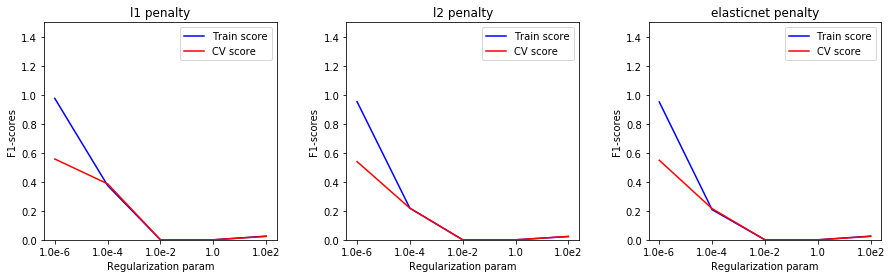

In [86]:
# Visualising the GCV
fig1 = plt.figure(figsize = (15,4))
fig1.subplots_adjust(wspace = 0.3)
axs = fig1.subplots(1,3)

hp_grid = logreg_gcv2['hyper_param_scores']

penalty_vals = ['l1', 'l2', 'elasticnet']

for i in range(len(penalty_vals)):
    item = penalty_vals[i]
    alpha_vals = hp_grid.alpha[(hp_grid.penalty == item)]
    train_scores = hp_grid.train_score[(hp_grid.penalty == item)]
    cv_scores = hp_grid.cv_score[(hp_grid.penalty == item)]    
    plot_labels = ('Regularization param', 'F1-scores', item + ' penalty')
    plot_gcv(alpha_vals, train_scores, cv_scores, axs[i], plot_labels)

In [15]:
start_time = datetime.datetime.now()

# Using the best estimator decided by above Grid search
log_reg_clf2 = logreg_gcv2['best_estimator']

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:00:00.000997



--------- Log-reg (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 11, 0.01%
1b. Number & percent of datapoints having 0 predicted tags: 732, 0.73%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          99.8%     99.0%     98.3%     98.6%   
java        99.8%     99.0%     98.5%     98.8%   
php         99.8%     99.5%     97.5%     98.5%   
javascript  99.8%     99.5%     97.4%     98.4%   
android     99.9%     99.3%     99.8%     99.6%   
jquery      99.9%     99.3%     98.9%     99.1%   
c++         99.9%     97.9%     99.7%     98.8%   
python      99.9%     99.5%     98.8%     99.1%   
mysql       100.0%    99.3%     99.3%     99.3%   
iphone      99.9%     98.9%     98.0%     98.4%   

Micro-avg   91.4%     98.8%     96.4%     97.6%   
Macro-avg   91.4%     98.5%     94.5%     96.4%   


Block execution time:  0:16:31.008776


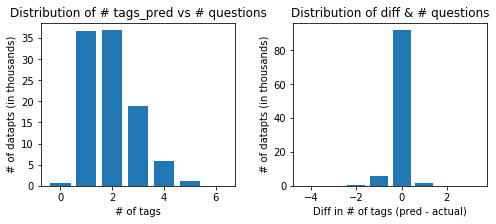

In [16]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = log_reg_clf2.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Log-reg (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Log-reg (OVR): CV data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 13, 0.05%
1b. Number & percent of datapoints having 0 predicted tags: 3857, 15.43%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          92.8%     60.9%     52.0%     56.1%   
java        95.2%     74.4%     59.6%     66.2%   
php         96.4%     84.1%     65.4%     73.6%   
javascript  94.9%     67.6%     51.3%     58.3%   
android     98.8%     93.6%     86.7%     90.0%   
jquery      97.7%     82.6%     75.1%     78.7%   
c++         97.4%     63.5%     60.8%     62.1%   
python      98.7%     87.4%     75.1%     80.8%   
iphone      97.4%     66.0%     52.3%     58.3%   
asp.net     97.9%     75.8%     54.9%     63.7%   

Micro-avg   20.8%     67.3%     47.6%     55.7%   
Macro-avg   20.8%     56.1%     38.1%     44.2%   


Block execution time:  0:03:05.092933


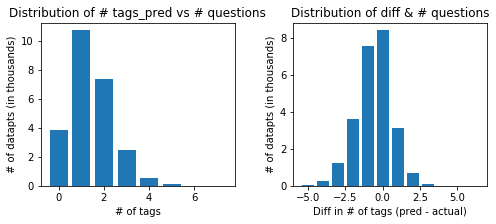

In [17]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_cv = log_reg_clf2.predict(cv_x)

# Generate performance report
analyse_prediction(cv_y, y_pred_cv, 10, vocab, "Log-reg (OVR): CV data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Log-reg (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 13, 0.05%
1b. Number & percent of datapoints having 0 predicted tags: 3909, 15.64%


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          92.9%     60.6%     51.1%     55.5%   
java        95.4%     75.3%     61.2%     67.5%   
php         96.6%     81.7%     67.7%     74.0%   
javascript  95.1%     70.6%     53.9%     61.1%   
android     98.8%     94.8%     84.5%     89.3%   
jquery      97.4%     83.7%     71.6%     77.1%   
c++         97.2%     64.5%     60.5%     62.4%   
python      98.6%     88.6%     71.3%     79.0%   
iphone      97.2%     60.6%     47.3%     53.1%   
html        96.8%     52.0%     30.6%     38.5%   

Micro-avg   20.7%     67.5%     47.5%     55.7%   
Macro-avg   20.7%     56.7%     37.8%     44.1%   


Block execution time:  0:03:37.450491


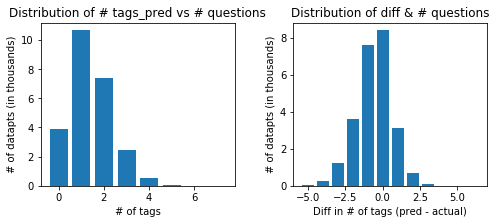

In [89]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = log_reg_clf2.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Log-reg (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

In [18]:
start_time = datetime.datetime.now()

# GridSearchCV for hyperparameter tuning of regularization paramter

# Defining the hyper parameter value to be experimented with
alpha_vals = []
start_val = 10**-8
for i in range(4):
    alpha_vals = alpha_vals + list(np.linspace(start_val, start_val*10, 4, endpoint = False))
    start_val *= 10

hyper_params3 = {'alpha': alpha_vals, 'penalty': ['l1']}
logreg_gcv3 = grid_search_cv(hyper_params3, train_x, train_y, cv_x, cv_y)

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Completed iteration: 1/17 | Time taken: 1:17:16.972767
Completed iteration: 2/17 | Time taken: 1:14:20.953848
Completed iteration: 3/17 | Time taken: 1:12:56.218370
Completed iteration: 4/17 | Time taken: 1:11:51.470323
Completed iteration: 5/17 | Time taken: 1:11:03.447037
Completed iteration: 6/17 | Time taken: 1:05:57.660479
Completed iteration: 7/17 | Time taken: 1:02:58.683420
Completed iteration: 8/17 | Time taken: 1:01:08.224700
Completed iteration: 9/17 | Time taken: 0:59:54.005386
Completed iteration: 10/17 | Time taken: 0:54:11.197451
Completed iteration: 11/17 | Time taken: 0:52:59.494402
Completed iteration: 12/17 | Time taken: 0:52:35.307252
Completed iteration: 13/17 | Time taken: 0:52:17.495162
Completed iteration: 14/17 | Time taken: 0:51:32.131768
Completed iteration: 15/17 | Time taken: 0:51:21.826481
Completed iteration: 16/17 | Time taken: 0:51:08.296649

Block execution time:  16:23:33.960162


In [19]:
print(logreg_gcv3['best_params'])
logreg_gcv3['hyper_param_scores']

{'alpha': 3.2499999999999994e-06, 'penalty': 'l1'}


,alpha,penalty,train_score,cv_score
0,1.000000e-08,l1,0.999945,0.547902
1,3.250000e-08,l1,0.999943,0.548414
2,5.500000e-08,l1,0.999938,0.547763
3,7.750000e-08,l1,0.999723,0.549641
4,1.000000e-07,l1,0.999935,0.550184
5,3.250000e-07,l1,0.999833,0.553662
6,5.500000e-07,l1,0.998990,0.555634
7,7.750000e-07,l1,0.994349,0.556310
8,1.000000e-06,l1,0.975342,0.560434
9,3.250000e-06,l1,0.672126,0.560439


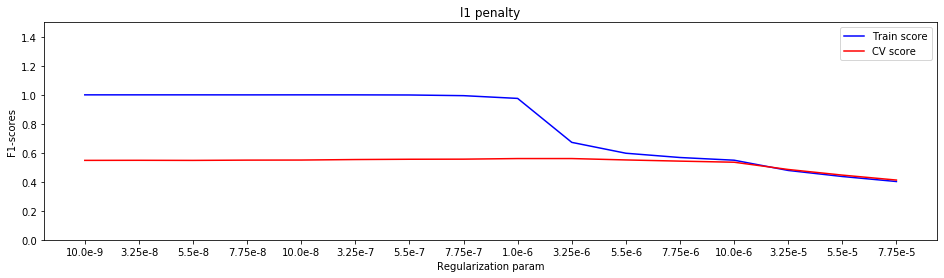

In [88]:
# Visualising the GCV
fig2 = plt.figure(figsize = (16,4))
fig2.subplots_adjust(wspace = 0.3)
axs = fig2.subplots(1)

hp_grid = logreg_gcv3['hyper_param_scores']

alpha_vals = hp_grid.alpha
train_scores = hp_grid.train_score
cv_scores = hp_grid.cv_score    
plot_labels = ('Regularization param', 'F1-scores', 'l1 penalty')
plot_gcv(alpha_vals, train_scores, cv_scores, axs, plot_labels)

In [20]:
start_time = datetime.datetime.now()

# Using the best estimator decided by above Grid search
log_reg_clf3 = logreg_gcv3['best_estimator']

print("Block execution time: ", datetime.datetime.now() - start_time)

Block execution time:  0:00:00



--------- Log-reg (OVR): Train data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 15, 0.02%
1b. Number & percent of datapoints having 0 predicted tags: 16052, 16.05%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          96.0%     85.7%     65.2%     74.0%   
java        97.0%     90.5%     69.5%     78.6%   
php         97.7%     91.6%     76.0%     83.1%   
javascript  97.2%     85.1%     71.5%     77.7%   
android     99.3%     96.5%     92.2%     94.3%   
jquery      98.2%     92.6%     75.8%     83.4%   
c++         98.4%     88.7%     67.7%     76.8%   
python      99.1%     93.9%     79.4%     86.0%   
mysql       99.0%     90.6%     78.7%     84.3%   
iphone      98.4%     80.1%     70.6%     75.1%   

Micro-avg   32.8%     84.8%     55.6%     67.2%   
Macro-avg   32.8%     77.7%     44.1%     54.0%   


Block execution time:  0:16:30.493301


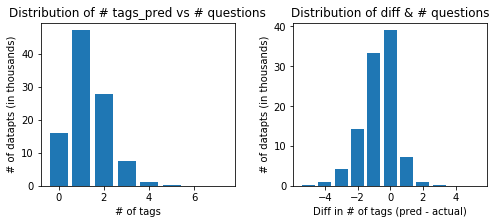

In [21]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_train = log_reg_clf3.predict(train_x)

# Generate performance report
analyse_prediction(train_y, y_pred_train, 10, vocab, "Log-reg (OVR): Train data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Log-reg (OVR): CV data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 15, 0.06%
1b. Number & percent of datapoints having 0 predicted tags: 4896, 19.58%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.5%     68.1%     49.9%     57.6%   
java        95.6%     80.4%     57.2%     66.9%   
php         96.7%     86.2%     67.0%     75.4%   
javascript  95.4%     71.1%     55.0%     62.0%   
android     98.9%     94.8%     87.1%     90.8%   
jquery      97.8%     86.3%     72.2%     78.7%   
c++         97.7%     73.8%     55.5%     63.3%   
python      98.7%     88.7%     72.6%     79.9%   
iphone      97.4%     65.1%     54.1%     59.1%   
asp.net     98.0%     80.6%     53.9%     64.6%   

Micro-avg   21.6%     71.1%     46.3%     56.0%   
Macro-avg   21.6%     57.7%     36.4%     43.3%   


Block execution time:  0:03:09.523144


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


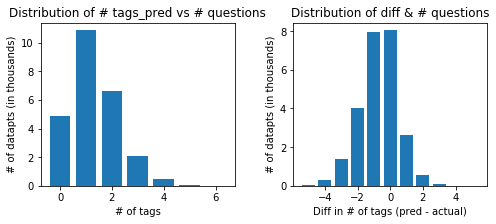

In [22]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_cv = log_reg_clf3.predict(cv_x)

# Generate performance report
analyse_prediction(cv_y, y_pred_cv, 10, vocab, "Log-reg (OVR): CV data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)


--------- Log-reg (OVR): Test data ---------

1a. Number & percent of datapoints having more than 5 predicted tags: 11, 0.04%
1b. Number & percent of datapoints having 0 predicted tags: 4916, 19.66%


2. Tag wise metrics: 

Tag        Accuracy Precision   Recall   F1-score 
------------------------------------------------
c#          93.5%     67.4%     49.2%     56.9%   
java        95.8%     80.5%     60.4%     69.0%   
php         96.8%     85.2%     68.0%     75.6%   
javascript  95.6%     74.4%     57.3%     64.7%   
android     98.8%     94.4%     85.7%     89.8%   
jquery      97.7%     89.8%     69.9%     78.6%   
c++         97.5%     73.6%     54.7%     62.7%   
python      98.7%     88.8%     71.7%     79.4%   
iphone      97.3%     60.7%     51.7%     55.9%   
html        96.9%     54.6%     31.2%     39.7%   

Micro-avg   21.6%     71.5%     46.1%     56.0%   
Macro-avg   21.6%     58.6%     36.0%     43.2%   


Block execution time:  0:03:16.044641


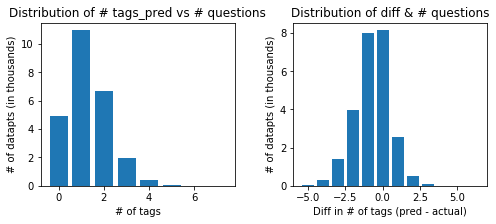

In [90]:
start_time = datetime.datetime.now()

# Predict the tags using the model trained above
y_pred_test = log_reg_clf3.predict(test_x)

# Generate performance report
analyse_prediction(test_y, y_pred_test, 10, vocab, "Log-reg (OVR): Test data")

print("\nBlock execution time: ", datetime.datetime.now() - start_time)

In [94]:
joblib.dump(log_reg_clf1, 'E:/ai_projects/data_storage/Stack over flow tagging 5/models/log_reg_clf1.pkl')
joblib.dump(logreg_gcv2, 'E:/ai_projects/data_storage/Stack over flow tagging 5/models/logreg_gcv2.pkl')
joblib.dump(logreg_gcv3, 'E:/ai_projects/data_storage/Stack over flow tagging 5/models/logreg_gcv3.pkl')

['E:/ai_projects/data_storage/Stack over flow tagging 5/models/logreg_gcv3.pkl']